This notebook is used to create summary plots for Figure 4.

* Quantifying variability within cre line and compare to within clusters in cre lines. The goal is to show that clustering data reduces variability
* Size of clusters across cre lines. 



In [1]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_clustering as glm_clust

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


### Set up variables and stuff

In [7]:
threshold=0.1

In [8]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [9]:
# set params for saving
folder = '221006_figure4_summary_panels'
file_dir = '220627_shuffle_test/files'

In [10]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [11]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix, meta data and cluster labels

In [128]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [13]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [14]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))
original_cluster_labels = original_cluster_labels.reset_index(drop=True)
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,5
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [15]:
# trying to fix mismatch of clusters 4 and 5

indices = original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre'].index.values
original_cluster_labels.loc[indices, 'cluster_id']=original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre']['cluster_id'].replace([4,5], [5,4])
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,4
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [16]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

#### compute mean dropout scores for original data

In [17]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    
    
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    # if cre_line == 'Slc17a7-IRES2-Cre':
    #     print('changing stuff')
    #     mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
    #     mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

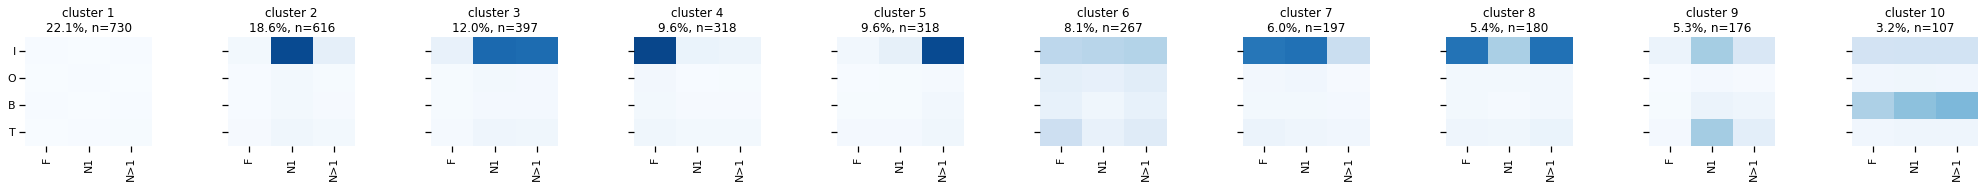

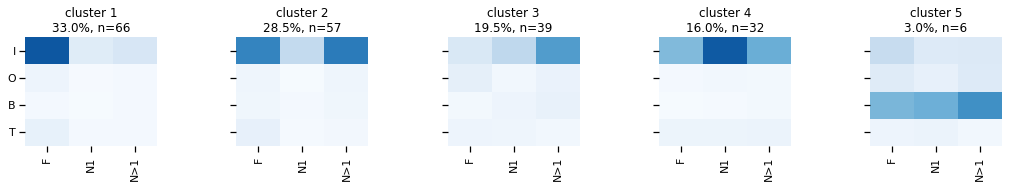

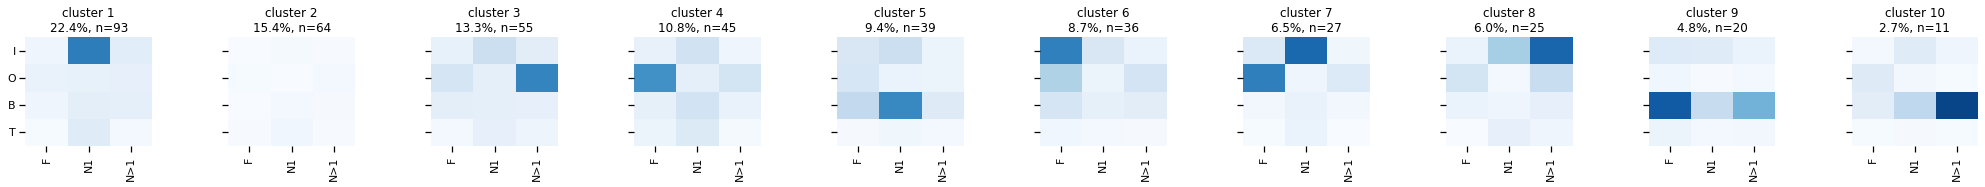

In [18]:
# plot original clusters
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


### Plot cluster heatmaps with SSE matrix together

In [20]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
  
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

<AxesSubplot:xlabel='experience_level'>

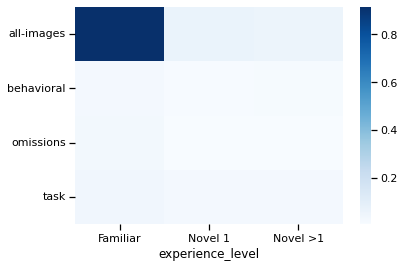

In [21]:
# plot cluster 4 to make sure its correct ('familiar')
sns.heatmap(cre_original_clusters_unstacked[cre_lines[0]][4], cmap='Blues')

### Compute variance

In [192]:
def compute_sse(feature_matrix):
    '''
    Computes Sum of Squared Error between each cell in feature matrix and the mean.
    
    INPUT: 
    feature_matrix (pd.DataFrame) dropout scores, rows are cell specimen ids
    
    Returns:
    SSE (list) of sse values between each cell and their mean.
    '''
    
    N = feature_matrix.shape[0]
    
    mean_values = feature_matrix.mean().values
    
    # SSE = []
    # for i in range(N):
    #     y = feature_matrix.iloc[i].values
    #     SSE.append(np.sum(np.subtract(mean_values,y)**2))
    
    SSE = np.sum(np.subtract(feature_matrix.values, mean_values)**2, axis=1)

    return SSE
    
    

In [162]:
def get_sse_df(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = vba_clust.get_cre_lines(cluster_df)
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
            
        # compute mean for clustered data
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'clustered_mean'
        variability_df.at[index,metric] = variability_df[variability_df.cre_line==cre_line][metric].mean()
        
        # compute mean for unclustered data
        if metric is 'sse':
            value = np.mean(compute_sse(cre_feature_matrix))
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'unclustered_mean'
        variability_df.at[index,metric] = value
                
        
    return variability_df
        
            
                
            
        

In [163]:
variability_df = get_sse_df(feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Vip-IRES-Cre
Sst-IRES-Cre
Slc17a7-IRES2-Cre


<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

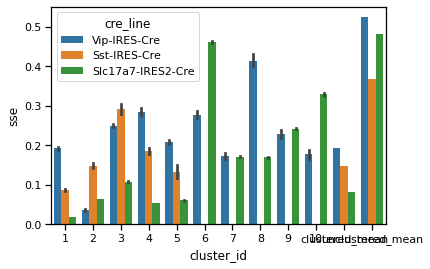

In [167]:
sns.barplot(data = variability_df, x = 'cluster_id', y='sse', hue='cre_line')

In [194]:
def get_sse_df_version2(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line', 'clustered'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = np.sort(vba_clust.get_cre_lines(cluster_df))
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                    'clustered': [True]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
        if metric is 'sse':
            values = compute_sse(cre_feature_matrix)
        variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [np.nan]*len(values),
                                    'clustered': [False]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                
        
    return variability_df
        
            
   

In [169]:
variability_df = get_sse_df_version2(feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Vip-IRES-Cre
Sst-IRES-Cre
Slc17a7-IRES2-Cre


In [172]:
utils.get_cre_line_colors()

[(1.0, 0.596078431372549, 0.5882352941176471),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)]

<AxesSubplot:xlabel='clustered', ylabel='sse'>

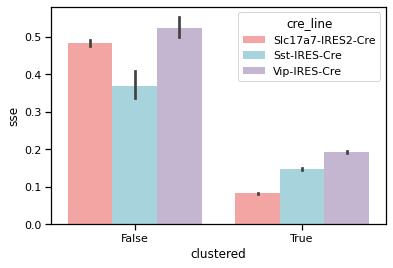

In [174]:
palette = utils.get_cre_line_colors()
sns.barplot(data = variability_df.sort_values('cre_line'), x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

In [195]:
variability_df2 = get_sse_df_version2(feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Slc17a7-IRES2-Cre
Sst-IRES-Cre
Vip-IRES-Cre


<AxesSubplot:xlabel='clustered', ylabel='sse'>

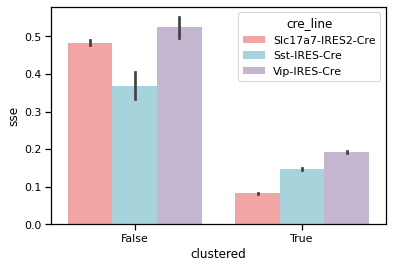

In [196]:
palette = utils.get_cre_line_colors()
sns.barplot(data = variability_df2, x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

In [180]:
variability_df2

array([0.        , 0.06045654, 0.01783166, 0.        , 0.        ,
       0.        , 0.        , 0.08489664, 0.97156264, 0.        ,
       0.00404454, 0.00982726])

In [191]:
len(np.sum(np.subtract(feature_matrix.values, y)**2, axis=1))

3921

<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

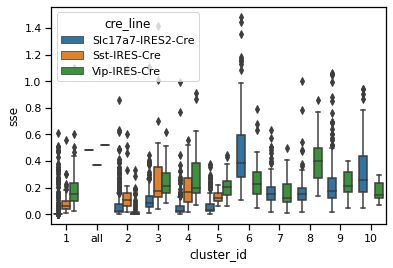

In [66]:
sns.boxplot(data=df, x='cluster_id', y='sse', hue='cre_line')


<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

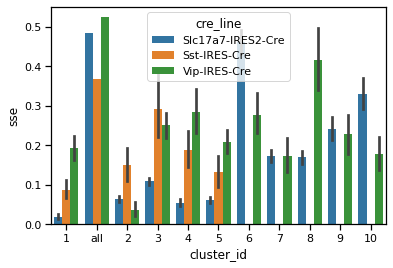

In [74]:
sns.barplot(data=df, x='cluster_id', y='sse', hue='cre_line')

<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

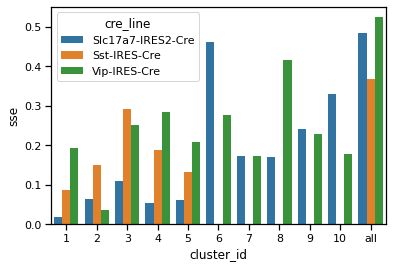

In [76]:
sns.barplot(data=df_2, x='cluster_id', y='sse', hue='cre_line')

In [88]:
tmp

,cluster_id,cre_line,sse
3521,1,Vip-IRES-Cre,0.061382
3522,1,Vip-IRES-Cre,0.182578
3523,1,Vip-IRES-Cre,0.213825
3524,1,Vip-IRES-Cre,0.255995
3525,1,Vip-IRES-Cre,0.441051
...,...,...,...
3941,10,Vip-IRES-Cre,0.120032
3942,10,Vip-IRES-Cre,0.124340
3943,10,Vip-IRES-Cre,0.264504
3944,10,Vip-IRES-Cre,0.072027


0.16817686679044236
0.1696162363818592
0.22457406749371583


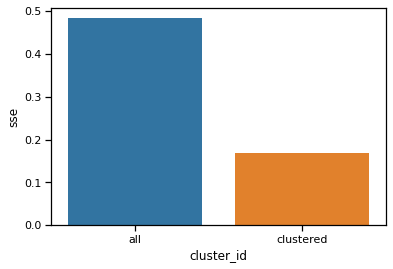

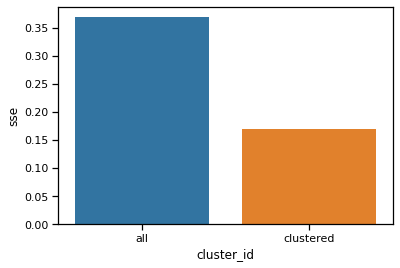

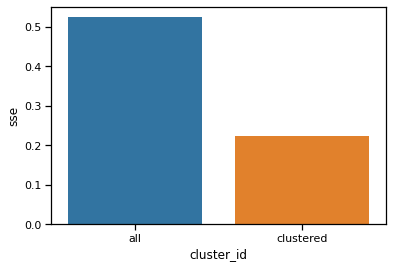

In [96]:
for cre_line in cre_lines:
    tmp = df[df.cre_line==cre_line]
    tmp2 = tmp[tmp.cluster_id != 'all']
    tmp3 = tmp[tmp.cluster_id == 'all']
    
    x = tmp2.groupby('cluster_id').mean().mean().values[0]
    print(x)
    tmp3 = tmp3.append(pd.DataFrame({'cluster_id':'clustered', 'cre_line':cre_line, 'sse':x}, index=[0]), ignore_index=True)
    
    
    fig, ax = plt.subplots(1,1)
    
    #ax = sns.barplot(data=tmp, x='cluster_id', y='sse')
    sns.barplot(data=tmp3, x='cluster_id', y='sse')
    

415

#### plot correlation bar plot

In [134]:
shuffle_corr_dict = {}
for shuffle_type in shuffle_types:
    corr_dict = {}
    for cre_line in cre_lines:
        corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                       shuffle_type_mean_dropout_scores,
                                                        shuffle_type = shuffle_type,
                                                       cre_line = cre_line)
    shuffle_corr_dict[shuffle_type] = corr_dict


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


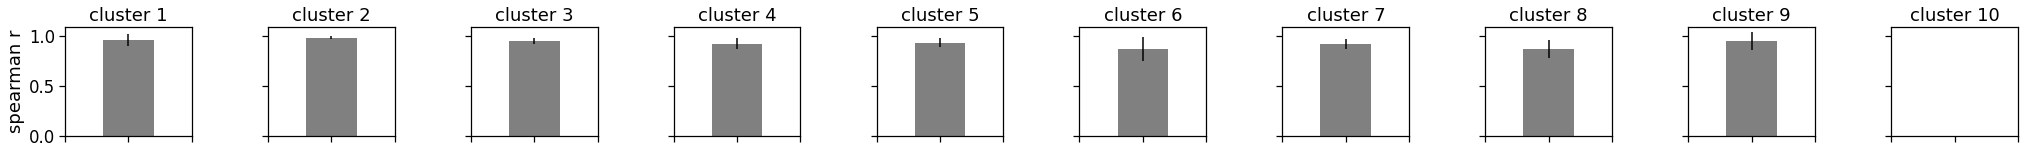

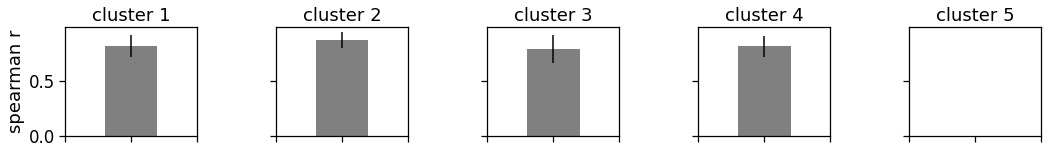

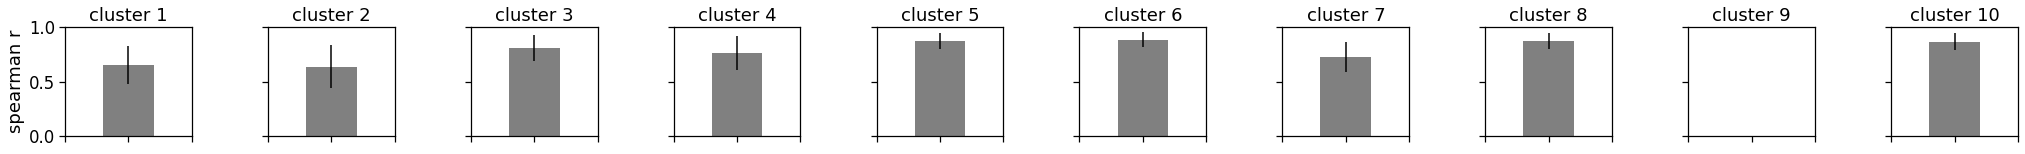

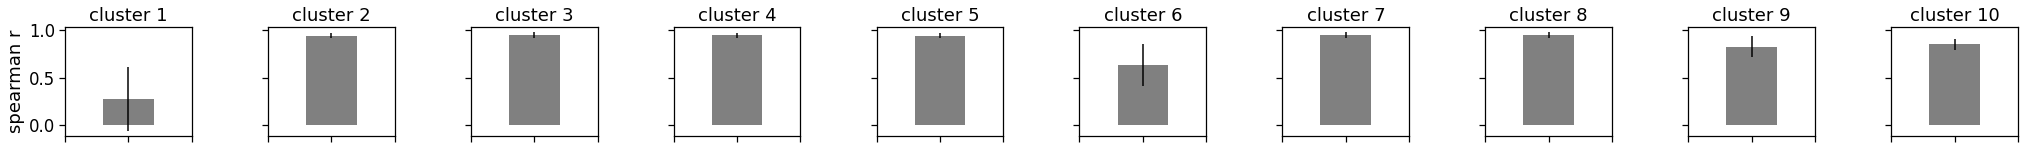

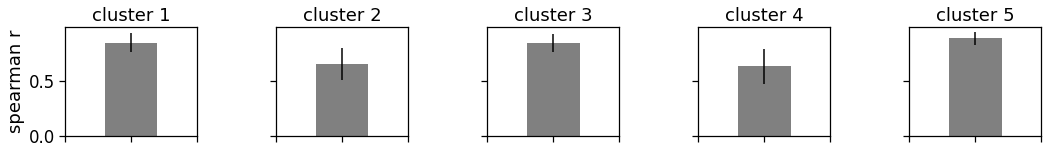

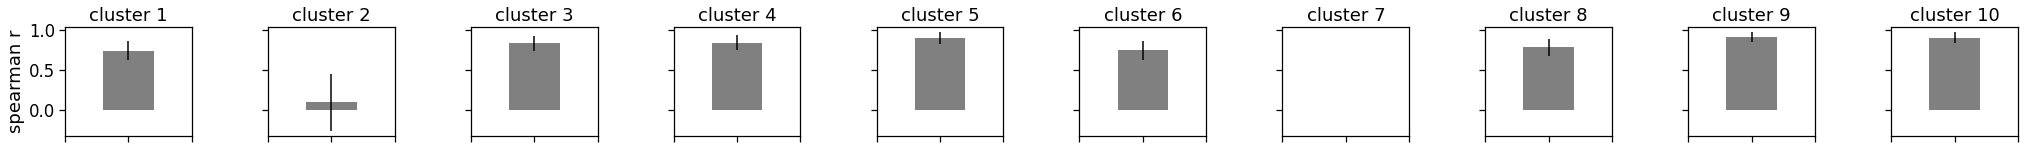

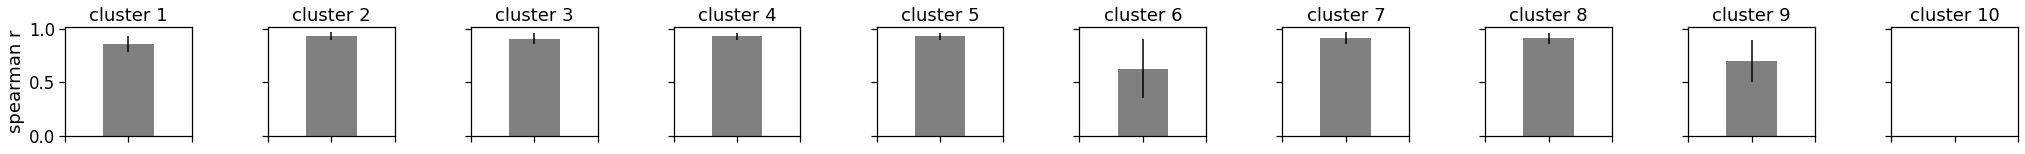

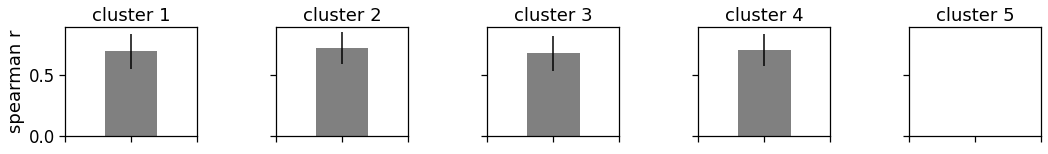

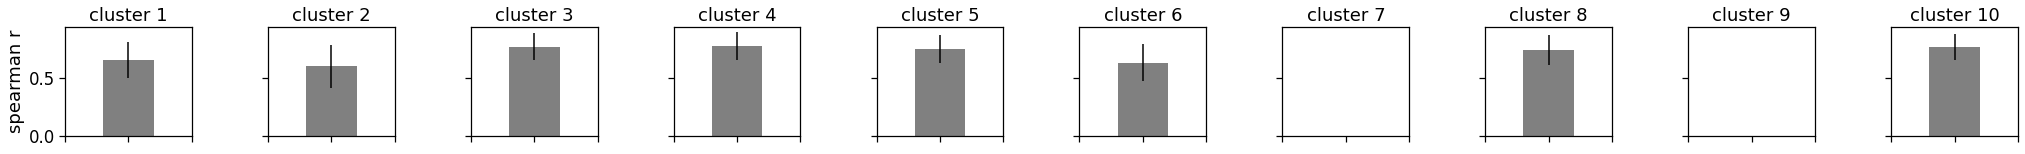

In [135]:

for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        corr_dict = shuffle_corr_dict[shuffle_type][cre_line]
        n_clusters = len(corr_dict.keys())
        figsize=(3.5*n_clusters,2)
        fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
        for i, cluster_id in  enumerate(corr_dict.keys()):
            ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
            ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                        color='k')
            ax[i].set_xticklabels([cluster_id])
            if i ==0 :
                ax[i].set_ylabel('spearman r')
            ax[i].set_xlabel('')
            ax[i].set_title(f'cluster {cluster_id}')
            ax[i].set_xticklabels('')
            ax[i].set_xlim([cluster_id-1, cluster_id+1])

        #plt.suptitle(cre_line + ' ' + shuffle_type)
        fig.subplots_adjust(hspace=1.2, wspace=0.6)
        utils.save_figure(fig, figsize, save_dir, f'{shuffle_type}{threshold}',
                      f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


### match SSE matric with cluster mean dropout plots

In [47]:
def make_dict(matrix):
    rows = np.shape(matrix)[0]
    new_dict = {}
    for row in range(rows):
        new_dict[row+1] = matrix[row]
    
    return new_dict

In [48]:
%%time
# compute mean SSE matrix of matched clusters
shuffle_type_SSE_all = {}
for shuffle_type in shuffle_types:
    cre_SSE_all = {}
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE[shuffle_type][cre_line].keys()
        cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][0]
        
        # create a data frame to collect sorted SSE from all n_boots
        SSE_values_sorted_df = pd.DataFrame(columns=['cluster_id', *cluster_ids])
        
        # run over all nboots and sort SSE using orignal cluster sort
        for n in n_boots:
            
            # Get matched map and SSE matrix for this n boot
            SSE_values = shuffle_type_SSE[shuffle_type][cre_line][n]
            SSE_map = shuffle_type_SSE_mapping[shuffle_type][cre_line][n]
            #print(SSE_map)
            # convert SSE matrix to df for easier operation
            nb_values_df = pd.DataFrame(make_dict(SSE_values))
            #print(nb_values_df)
            # make a copy which will be used to store sorted SSE values
            nb_sorted_df = nb_values_df.copy()
            # first sort SSE values
            for cluster_id in SSE_map.keys():
                matched_cluster_id = SSE_map[cluster_id] # matched shuddled cluster id
                
                # copy matched SSE value to a new location in df
                if matched_cluster_id!=-1:
                    nb_sorted_df.loc[cluster_id-1][:] = nb_values_df.loc[matched_cluster_id-1][:].values
                else:
                    #nb_sorted_df.loc[cluster_id-1][cluster_id]=np.nan
                    nb_sorted_df.loc[cluster_id-1][:]=np.nan
            
            
            # reset index and rename cluster id column
            nb_sorted_df = nb_sorted_df.reset_index(drop=True)
            nb_sorted_df['cluster_id'] = np.arange(1, len(cluster_ids)+1)
            
            
            # append to larger df with all n_boots
            SSE_values_sorted_df = SSE_values_sorted_df.append(nb_sorted_df, ignore_index=True)
        cre_SSE_all[cre_line] = SSE_values_sorted_df
    shuffle_type_SSE_all[shuffle_type] = cre_SSE_all
                
    
    

Wall time: 18.1 s


#### plot heatmap of mean SSE values by with cluster id heatmaps

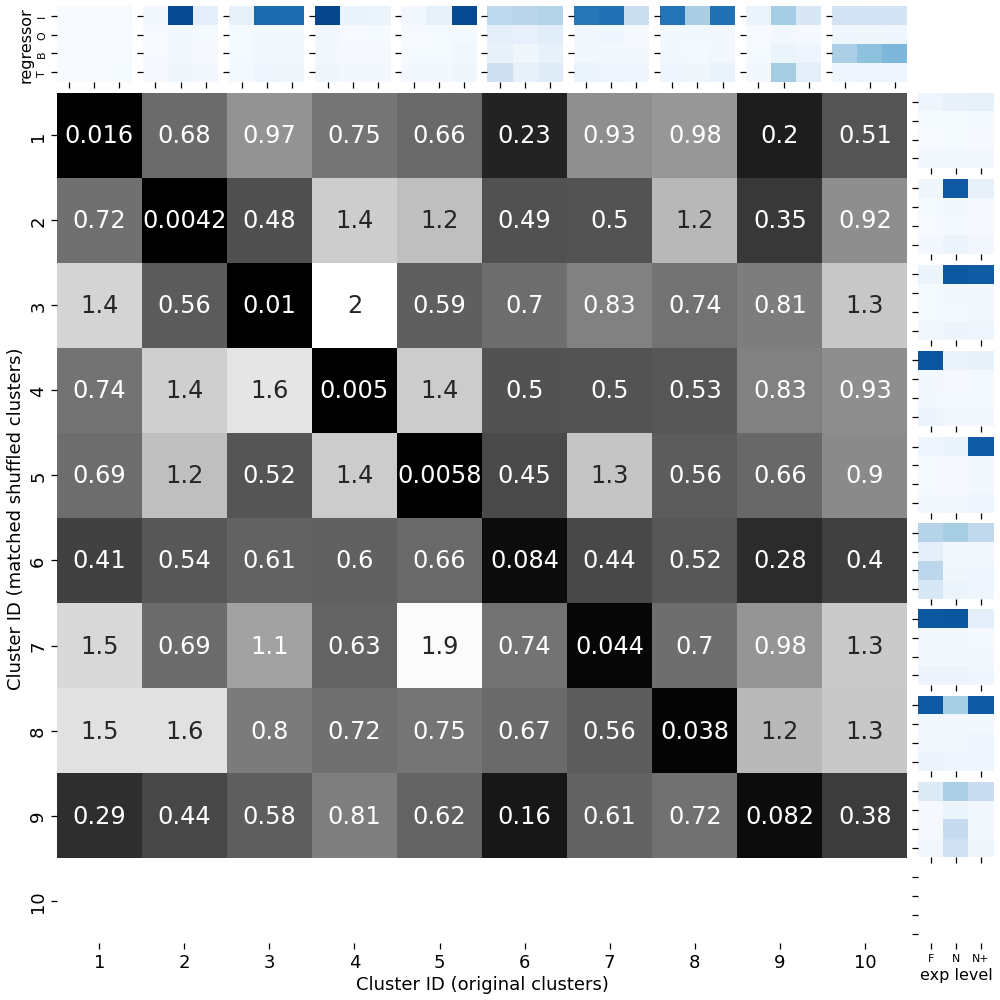

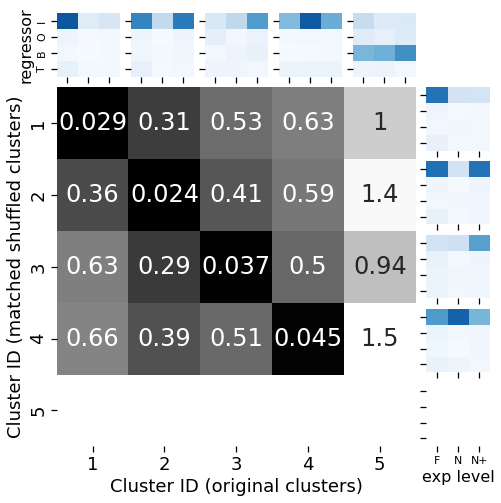

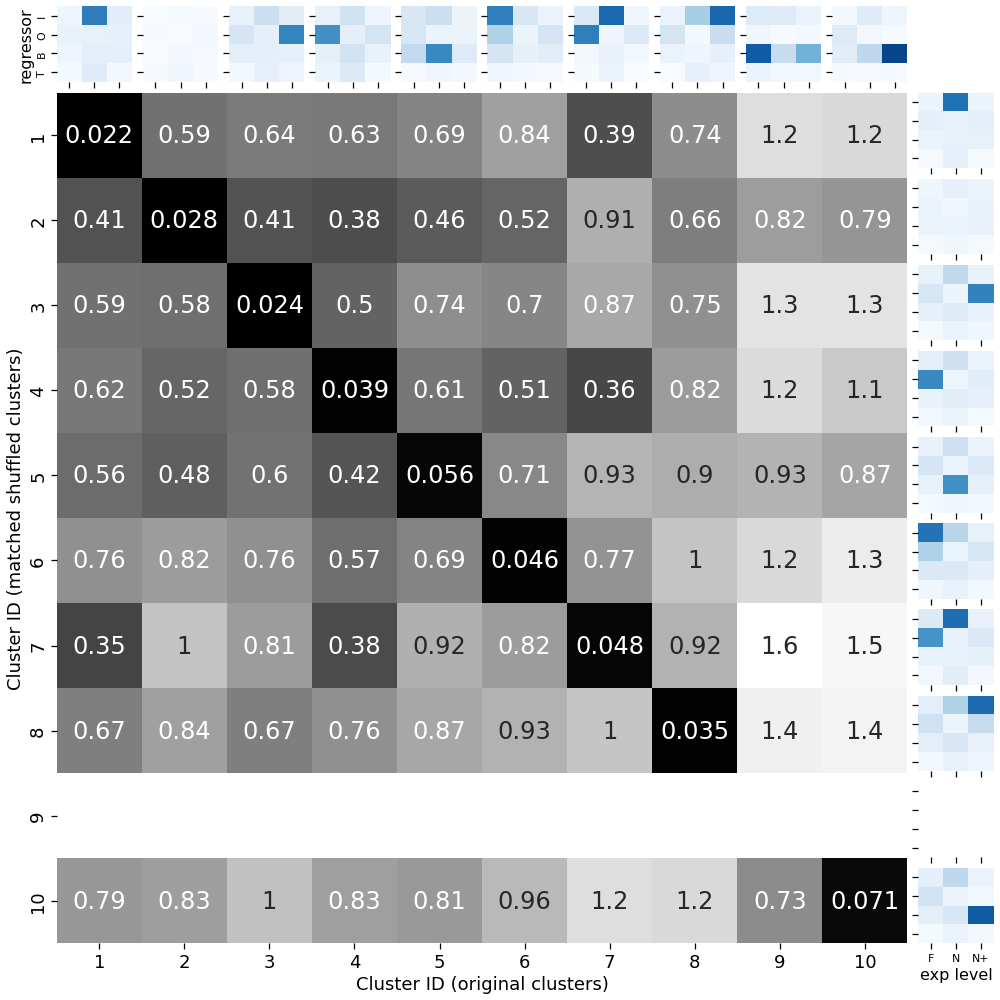

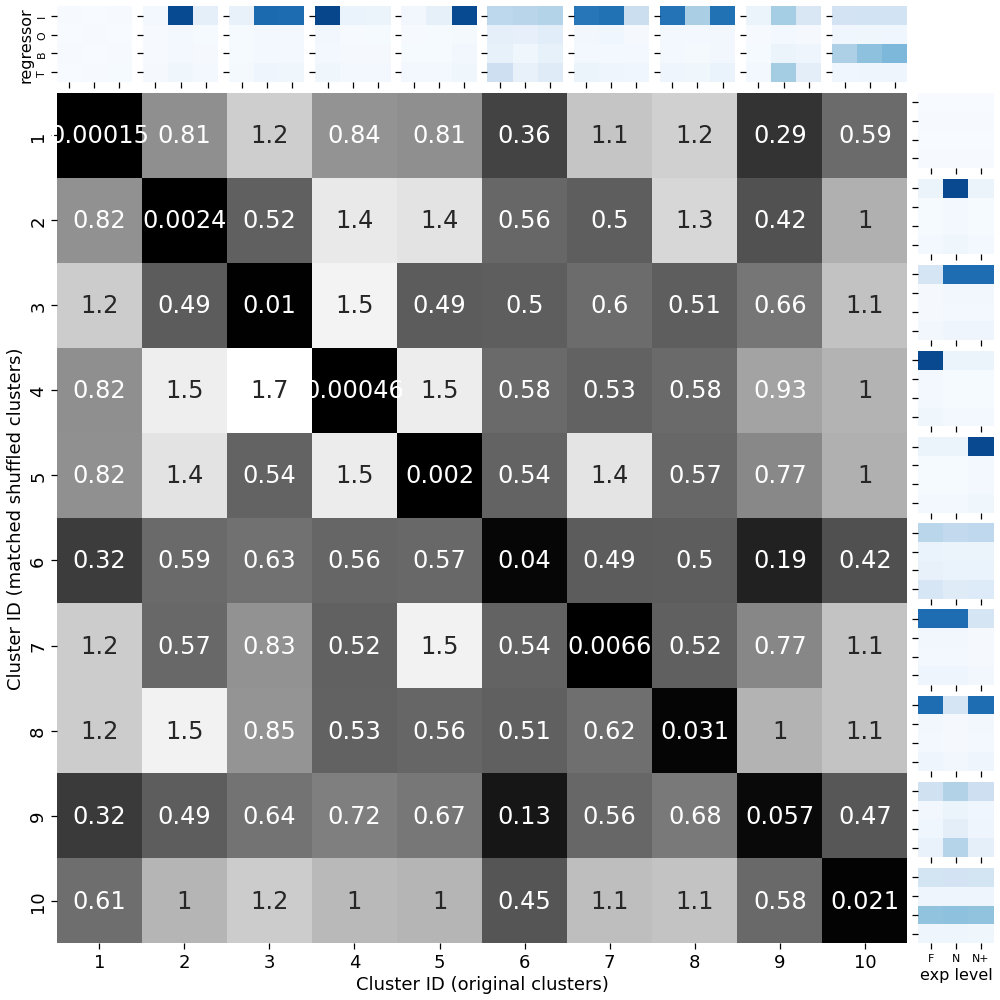

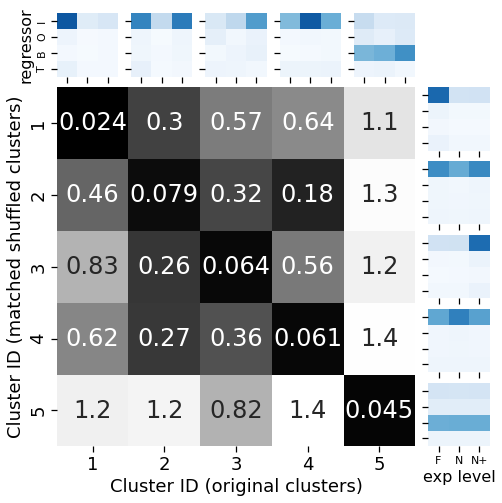

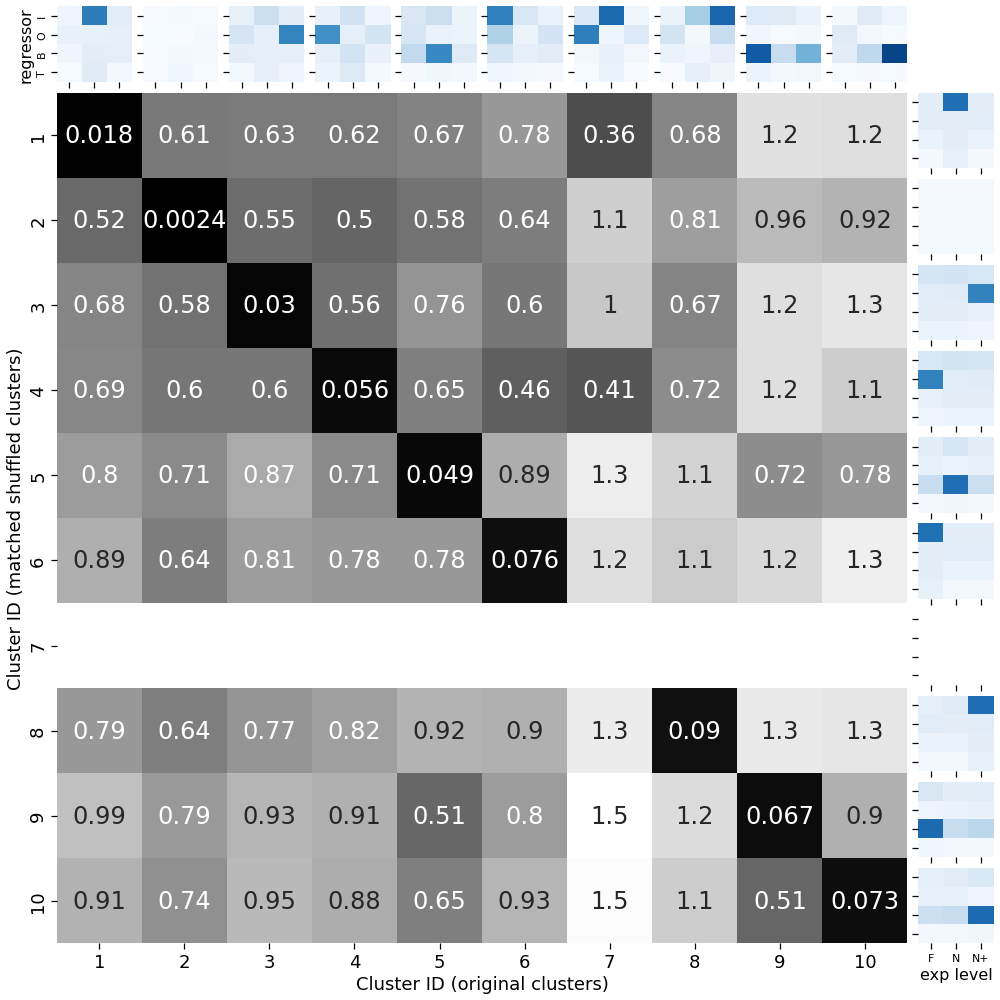

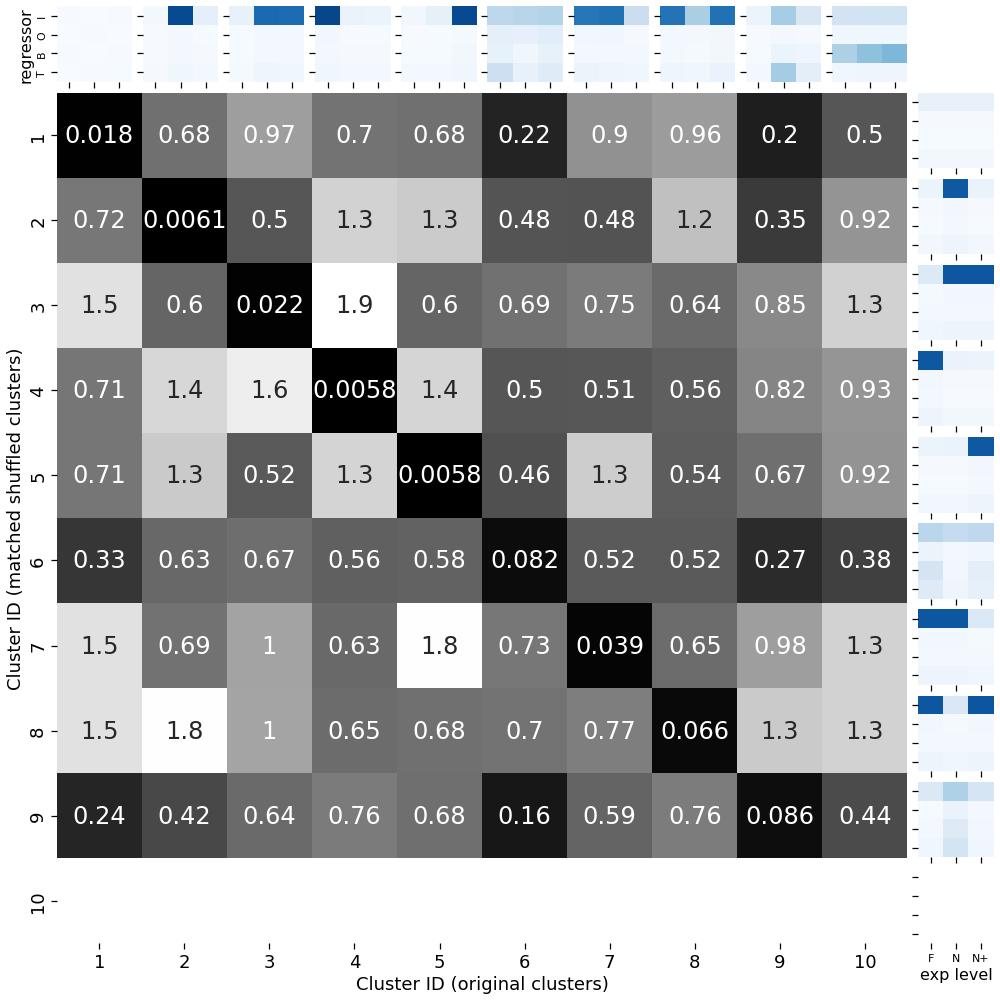

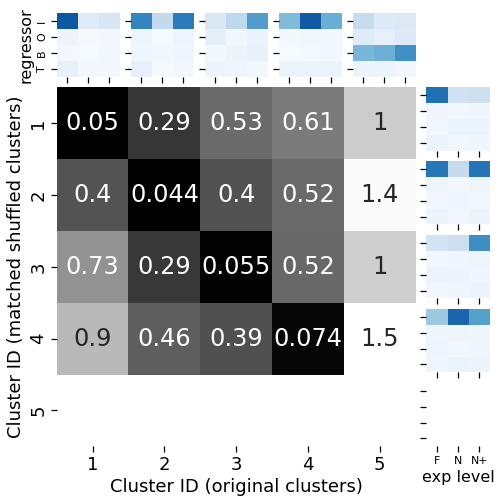

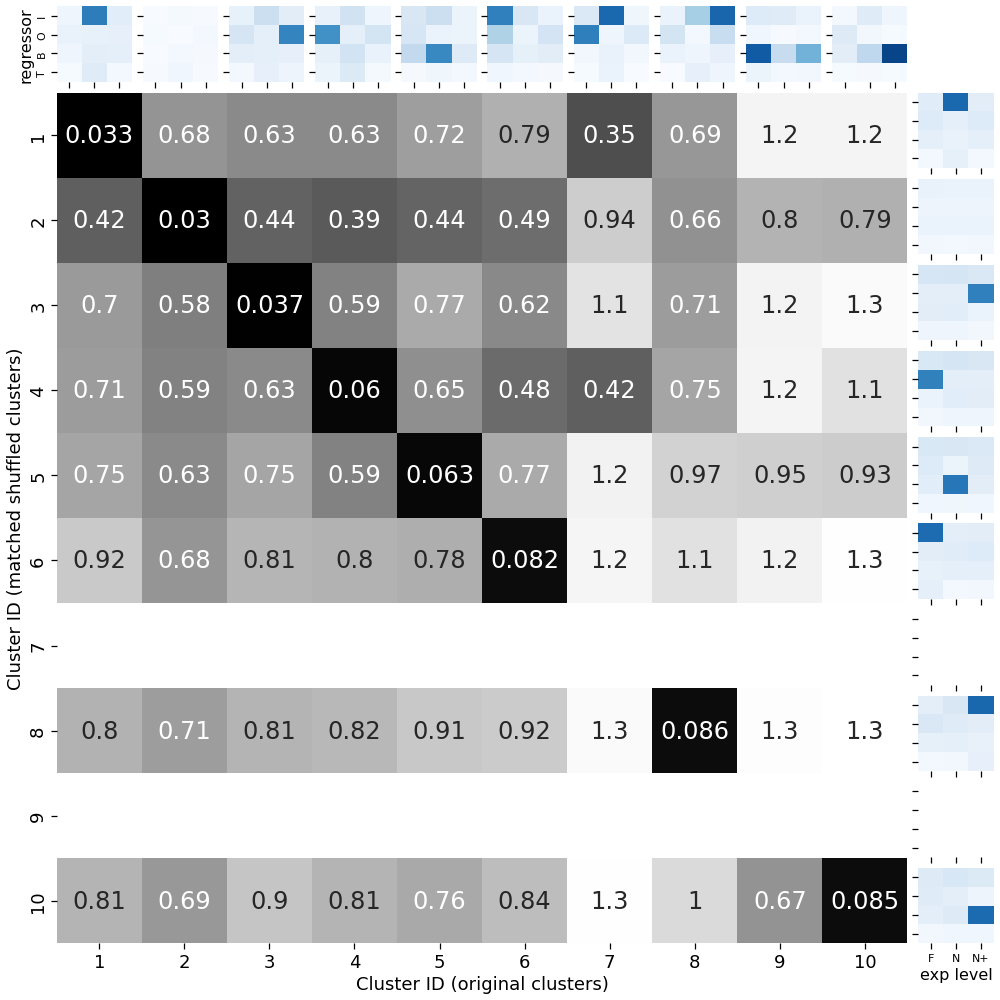

In [49]:
### make one mean figure with diagonal SSE matching plot

import matplotlib.gridspec as gr
figsizes =  [(14,14), (7, 7), (14,14)]
for shuffle_type in shuffle_types:
    for c,cre_line in enumerate(cre_lines):
        SSE_mapping = shuffle_type_SSE_mapping
        
        shuffled = vba_clust.get_matched_clusters_means_dict(SSE_mapping, shuffle_type_mean_dropout_scores_unstacked, metric='mean', shuffle_type=shuffle_type,
                                    cre_line=cre_line)      
        original = cre_original_clusters_unstacked[cre_line]
        cluster_ids = shuffled.keys()
        n_clusters = len(cluster_ids)
            
            
        gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
        fig = plt.figure(figsize = figsizes[c])
            
        # plot original
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[0, i])
            ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            if i!=0:
                ax.set_yticklabels('')
            else:
                ax.set_ylabel('regressor', fontsize=16)
            ax.set_xticklabels('')
            ax.set_xlabel('')

        # plot shuffled clusters
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[cluster_id, n_clusters])
            if shuffled[cluster_id].sum().sum() != 0:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            else:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Greys",vmin=0, vmax=1,cbar=False, ax=ax)
                
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            if cluster_id !=n_clusters:
                ax.set_xticklabels('')
            else:
                ax.set_xlabel('exp level', fontsize=16)


         # Plot SSE
        tmp = shuffle_type_SSE_all[shuffle_type][cre_line].groupby('cluster_id').mean()        
        labels=np.arange(1,len(tmp)+1)
        ax = fig.add_subplot(gs[1:,:n_clusters])
        ax=sns.heatmap(tmp, annot=True, cmap = 'Greys_r', annot_kws= {"size": 24},
                            yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
        
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
        ax.set_ylabel('Cluster ID (matched shuffled clusters)', fontsize=18)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
        ax.set_xlabel('Cluster ID (original clusters)', fontsize=18)

        plt.tight_layout()
        utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder='mean_SSE_plots',
                      fig_title=f'mean_SSE_heatmap_{shuffle_type}{threshold}_{cre_line[:3]}_tmp')
        


### Statistics

In [50]:
from scipy.stats import chisquare
#from scipy.stats import power_divergence
#from scipy.stats import fisher_exact

In [51]:
def stats(df,cre_line, shuffle_type):
    '''
        Performs chi-squared tests to asses whether the observed cell counts in each area/depth differ
        significantly from the average for that cluster. 
    '''    

    # compute cell counts in each area/cluster
    table = df.query('cre_line == @cre').groupby(['cluster_id','location'])['cell_specimen_id'].count().unstack()
    table = table[areas]
    table = table.fillna(value=0)

    # compute proportion for null hypothesis that areas have the same proportions
    table['total_cells'] = table.sum(axis=1)
    table['null_mean_proportion'] = table['total_cells']/np.sum(table['total_cells'])

    # second table of cell counts in each area/cluster
    table2 = df.query('cre_line == @cre').groupby(['cluster_id','location'])['cell_specimen_id'].count().unstack()
    table2 = table2[areas]
    table2 = table2.fillna(value=0)

    # compute estimated frequency of cells based on average fraction for each cluster
    for a in areas:
        table2[a+'_chance_count'] = table2[a].sum()*table['null_mean_proportion']

    # perform chi-squared test
    area_chance = [area+'_chance_count' for area in areas]
    for index in table2.index.values:
        f = table2.loc[index][areas].values
        f_expected = table2.loc[index][area_chance].values
        
        # Manually doing check here bc Im on old version of scipy
        assert np.abs(np.sum(f) - np.sum(f_expected))<1, 'f and f_expected must be the same'
        out = chisquare(f,f_expected)
        table2.at[index, 'pvalue'] = out.pvalue
        table2.at[index, 'significant'] = out.pvalue < 0.05

    # Use Benjamini Hochberg Correction for multiple comparisons
    table2 = add_hochberg_correction(table2) 
    return table2

In [52]:

def add_hochberg_correction(table, test='chi_squared_'):
    '''
        Performs the Benjamini Hochberg correction
    '''    
    table = table.sort_values(by=test+'pvalue').reset_index()
    
    # compute the corrected pvalue based on the rank of each test
    # Need to use rank starting at 1
    table['imq'] = (1+table.index.values)/len(table)*0.05
    # print(table)

    # Find the largest pvalue less than its corrected pvalue
    # all tests above that are significant
    table['bh_significant'] = False
    passing_tests = table[table[test+'pvalue'] < table['imq']]
    
    if len(passing_tests) >0:
        last_index = table[table[test+'pvalue'] < table['imq']].tail(1).index.values[0]
        # print(last_index)
        table.at[last_index,'bh_significant'] = True
        table.at[0:last_index,'bh_significant'] = True
    
    # reset order of table and return
    return table.sort_values(by='cluster_id')

In [53]:
# chi_squared test

cluster_statistics_df = pd.DataFrame(columns = ['shuffle_type', 'cre_line', 'cluster_id', 'cluster_size', 'shuffle_mean', 
                                                'chi_squared_pvalue', 'significant'])
index=0
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        
        table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
        # original cluster sizes
        table2 = cre_original_cluster_sizes[cre_line]
        
        for cluster_id in table2.index:
            f_observed = [table.loc[cluster_id], table2.sum()-table.loc[cluster_id]]
            f_expected = [table2.loc[cluster_id], table2.sum()-table2.loc[cluster_id]]
       
            out =chisquare(f_observed, f_expected)
            cluster_statistics_df.at[index, 'shuffle_type'] = shuffle_type
            cluster_statistics_df.at[index, 'cre_line'] = cre_line
            cluster_statistics_df.at[index, 'cluster_id'] = cluster_id
            cluster_statistics_df.at[index, 'cluster_size'] = table2.loc[cluster_id]
            cluster_statistics_df.at[index, 'shuffle_mean'] = table.loc[cluster_id]
            cluster_statistics_df.at[index, 'chi_squared_pvalue'] = out.pvalue
            cluster_statistics_df.at[index, 'significant'] = out.pvalue <= 0.05
            index=index+1
        

In [54]:
first = True
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        table = cluster_statistics_df[(cluster_statistics_df.cre_line == cre_line) &
                                      (cluster_statistics_df.shuffle_type == shuffle_type)]
        test = add_hochberg_correction(table)
        if first is True:
            stats_table = add_hochberg_correction(table)
            first = False
        else:
            stats_table = stats_table.append(add_hochberg_correction(table), ignore_index=True)
        
        

#### plots with statistics of cluster sizes

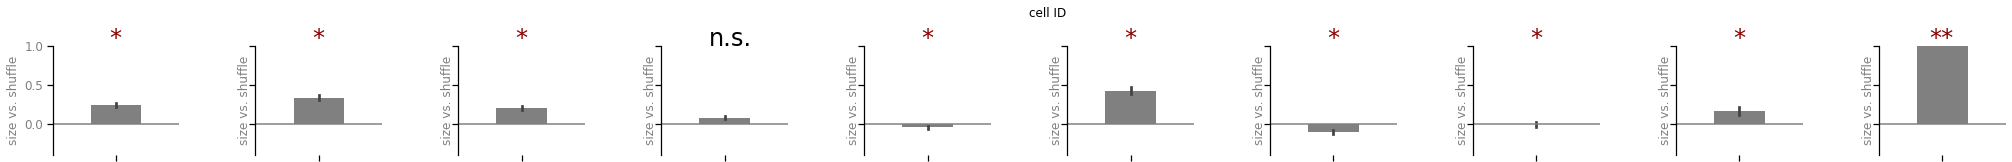

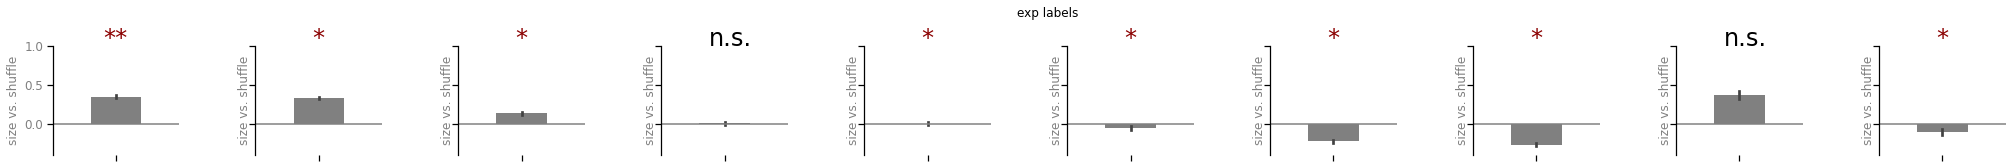

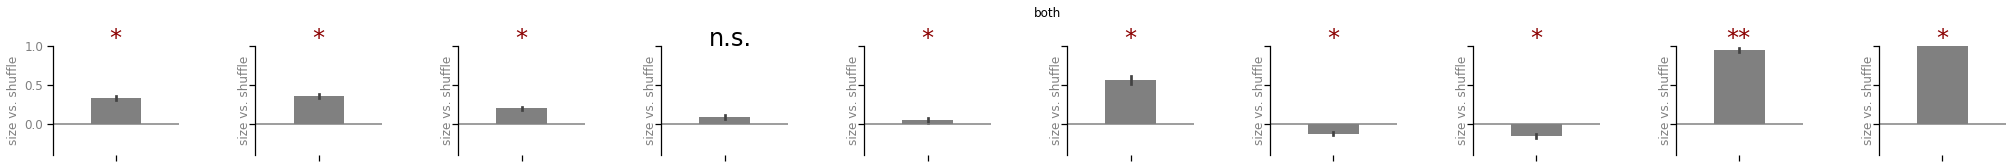

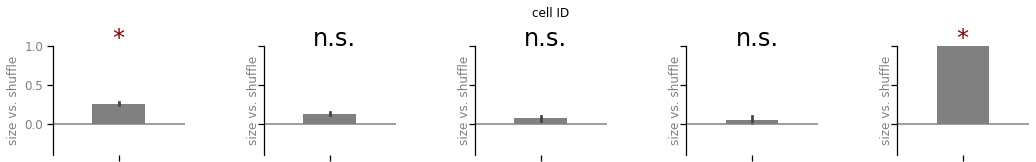

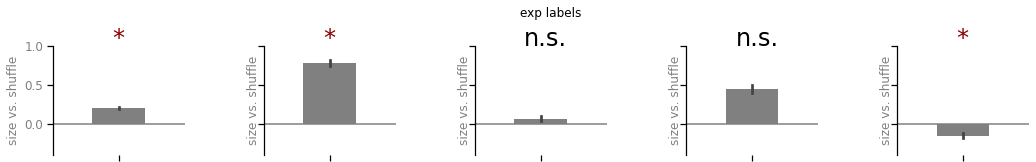

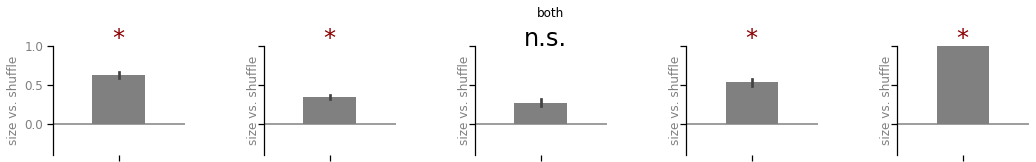

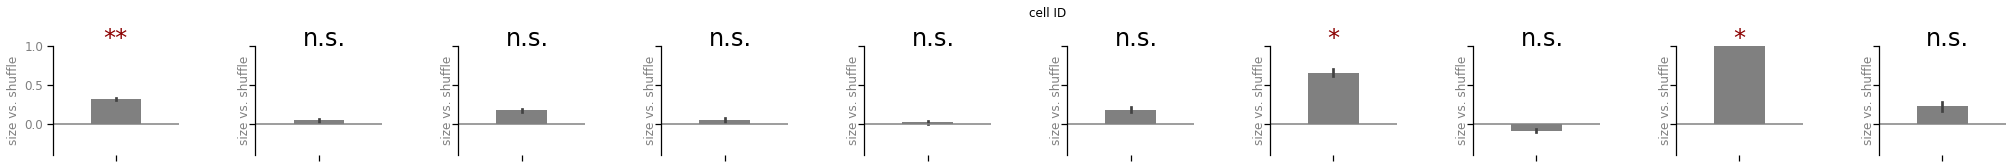

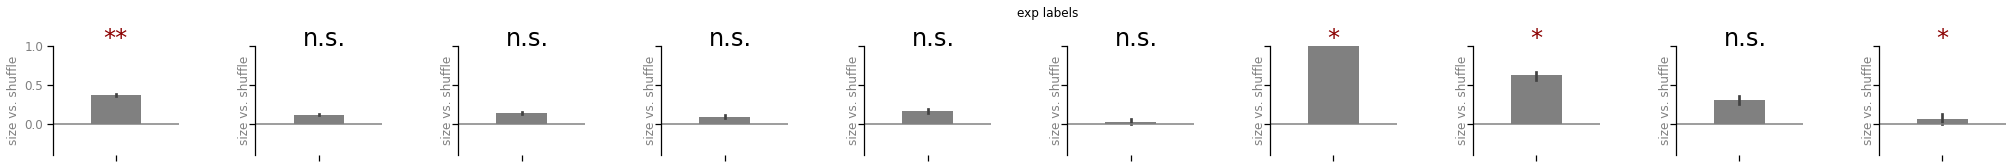

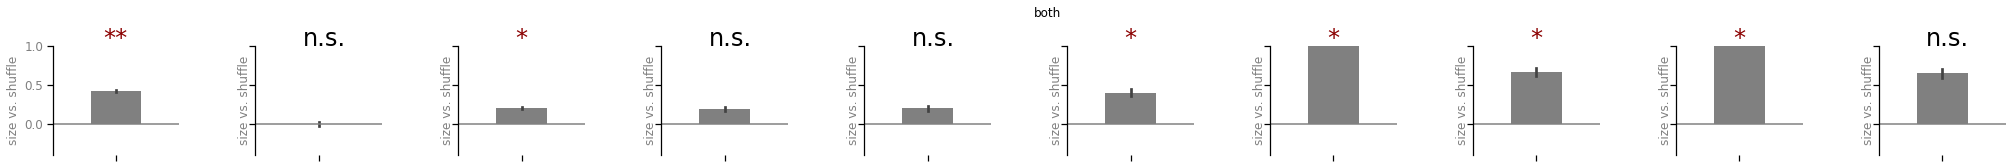

In [55]:
%%capture --no-display 
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size(cluster_size_difference_df,  
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                   folder = f'cluster_size_diff_plots_{threshold}', 
                                                    stats_table = stats_table)

#### plot stats_table

In [57]:
difference = (stats_table['cluster_size'] - stats_table['shuffle_mean'])/(stats_table['cluster_size'] + stats_table['shuffle_mean'])

In [58]:
stats_table.loc[difference.index.values, 'cluster_diff'] = difference

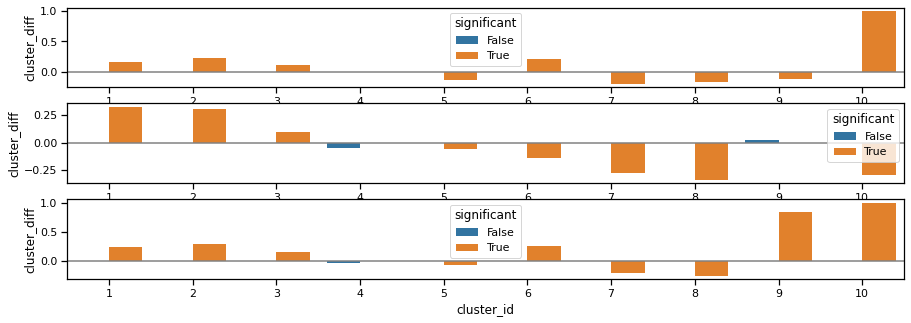

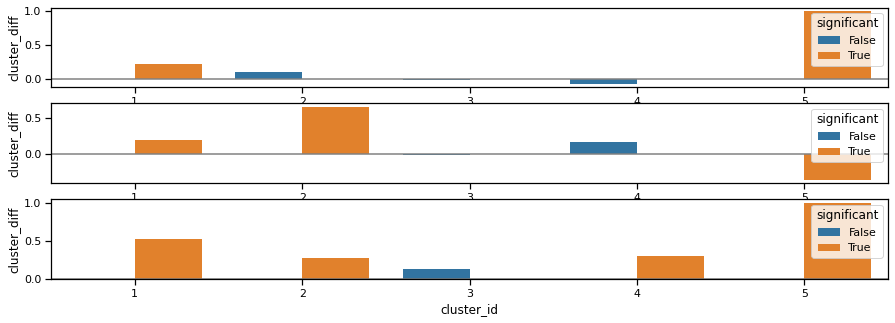

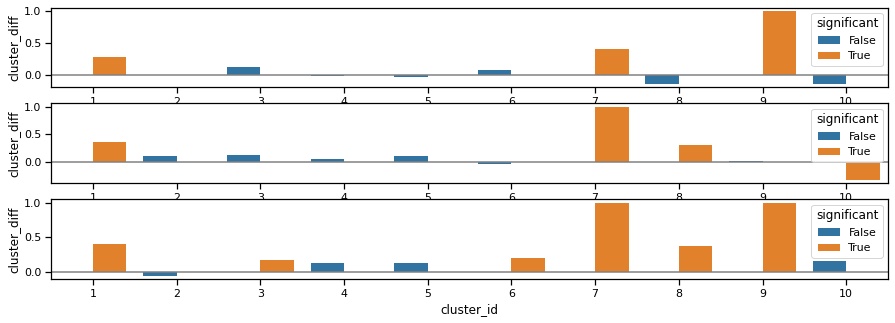

In [59]:
for cre_line in cre_lines:

    fig, ax = plt.subplots(3,1, figsize = (15,5))
    for s, shuffle_type in enumerate(shuffle_types):
        tmp = stats_table[(stats_table['shuffle_type']==shuffle_type) &
                   (stats_table['cre_line']==cre_line)]
        
        ax[s] = sns.barplot(data=tmp, x = 'cluster_id', 
                            y = 'cluster_diff', hue='significant',ax=ax[s] )
        ax[s].axhline(y=0, color='Grey')
        

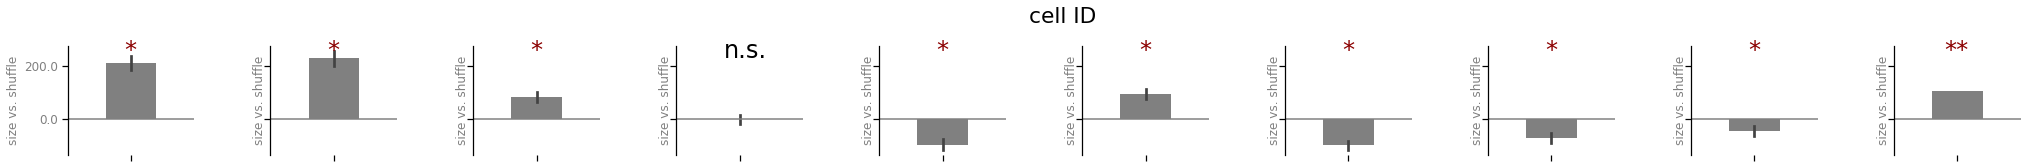

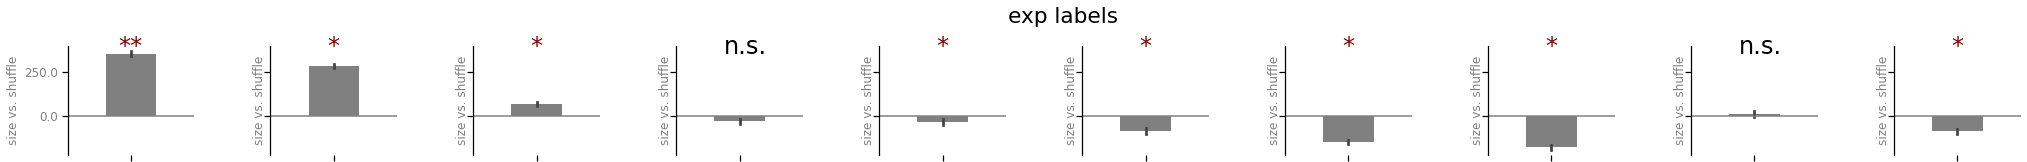

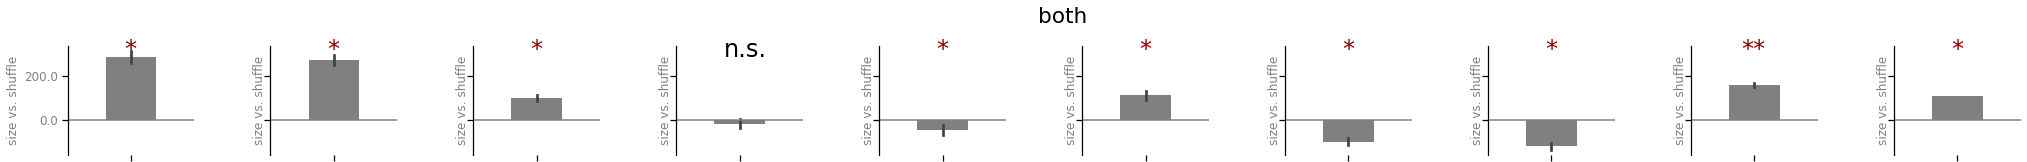

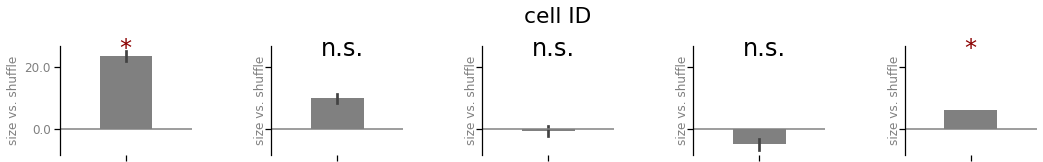

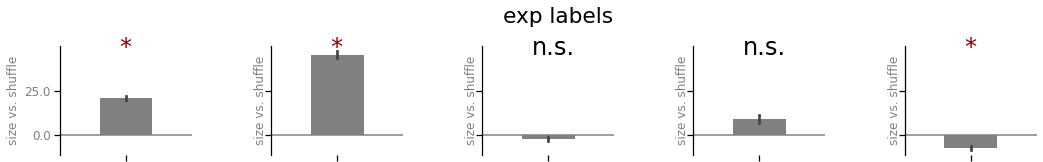

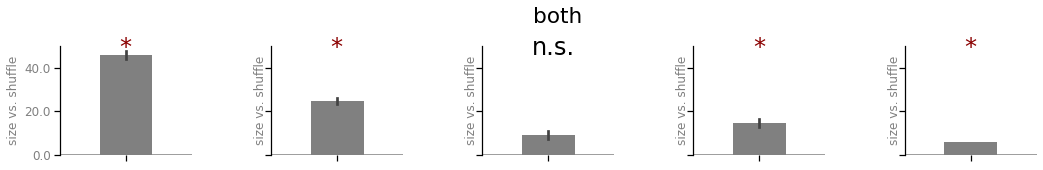

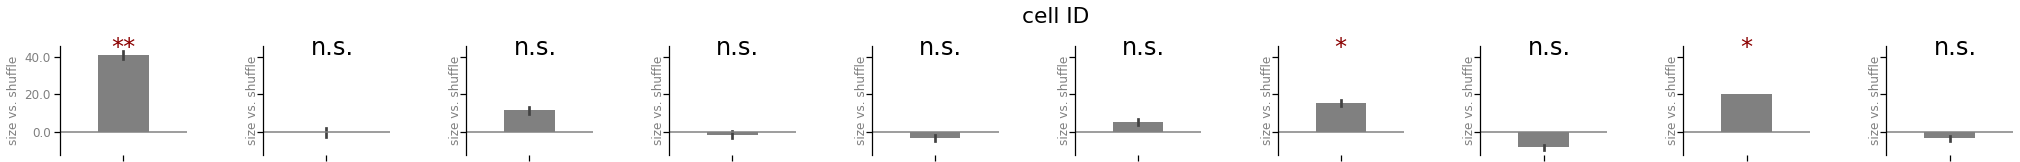

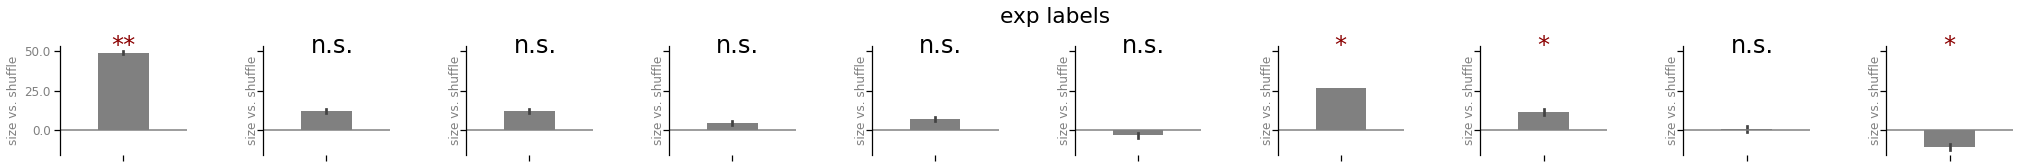

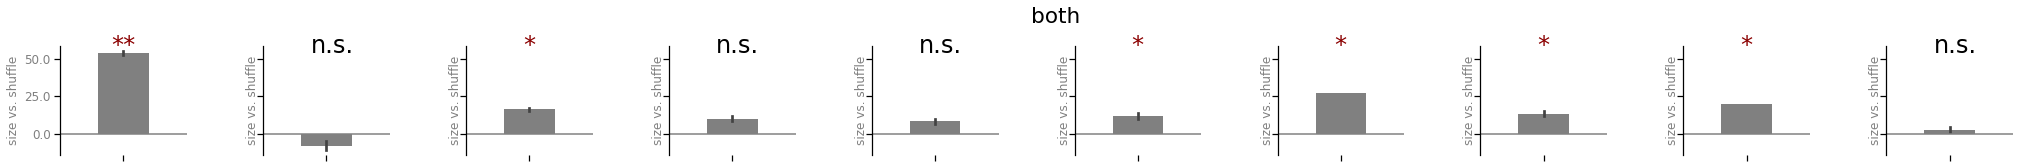

In [75]:
%%capture --no-display 
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size(cluster_size_difference_df,  
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                    diff_column = 'abs_cluster_size_diff',
                                                   folder = f'abs_cluster_size_diff_plots_{threshold}', 
                                                    stats_table = stats_table)

#### Plot proportions of clusters by depth or area 

In [280]:
table, stats = vba_clust.get_proportion_cells_rel_cluster_average(df_meta, cre_lines, columns_to_groupby=['layer'])

In [299]:
# import pickle
# file = open(os.path.join(save_dir,'proportions_table.pkl'), 'wb')
# # dump information to the file
# pickle.dump(table, file)
# # close the file
# file.close()

array([<AxesSubplot:title={'center':'Exc cluster 6'}>,
       <AxesSubplot:xlabel='proportion'>,
       <AxesSubplot:title={'left':'8.1%'}>], dtype=object)

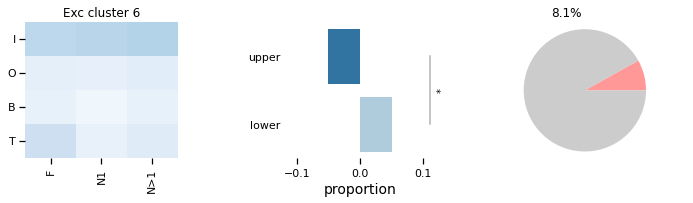

In [288]:
# testing out this function
vba_clust.plot_cluster_data(df_meta, feature_matrix, cre_line = cre_lines[0], cluster_id=6, multi_session_df=None,
                      columns_to_groupby=['layer'], change=False, omitted=True,
                      abbreviate_features=True, abbreviate_experience=True,
                      save_dir=None, ax=None)

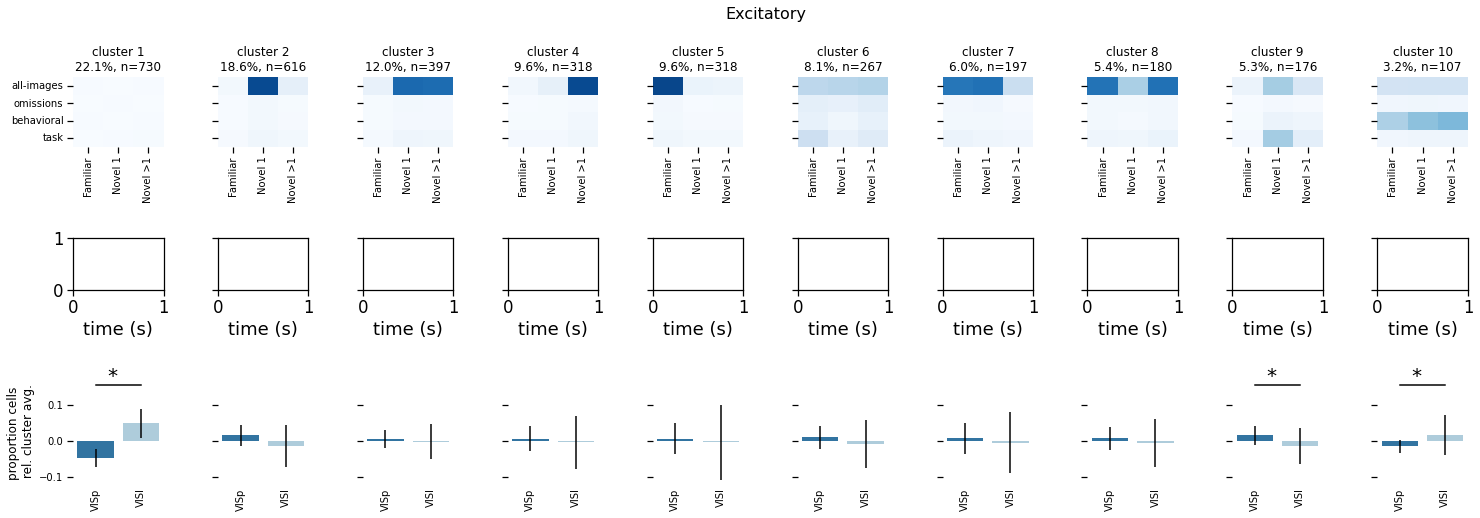

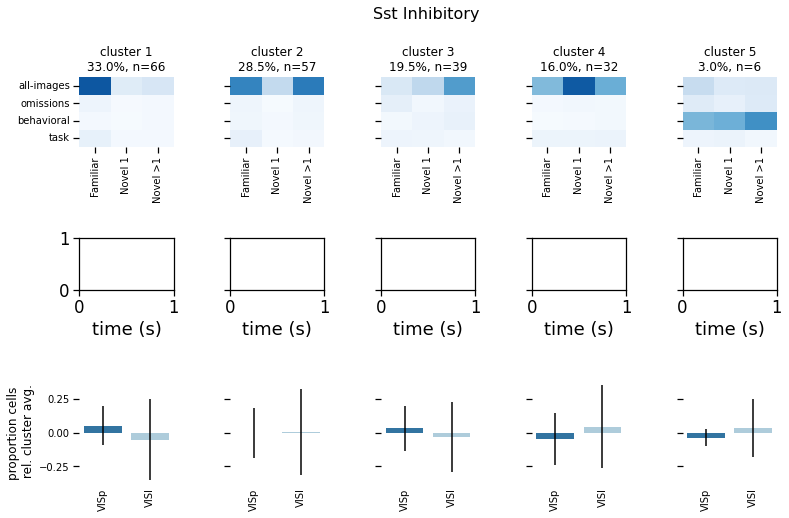

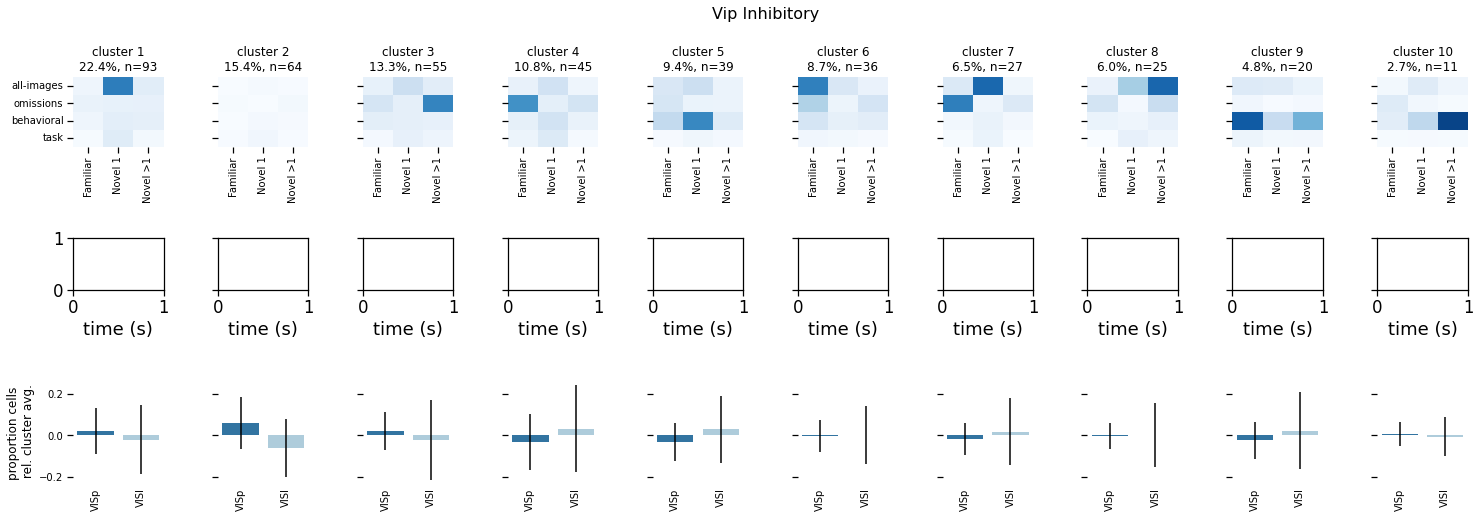

In [297]:
# this plot doesnt work without multi_session_df

for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, feature_matrix, multi_session_df=None, cre_line = cre_line,
                                     columns_to_groupby=['targeted_structure'], change=False, omitted=True,
                                     sort_order=None, save_dir=save_dir, folder='cluster_proportions_plot/areas', suffix='', alpha=0.05)


In [205]:
# # shuffled cluster sizes means
# shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
        
#         table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
#         # original cluster sizes
#         table2 = cre_original_cluster_sizes[cre_line]

#         # convert to shuffled proportions
#         table_proportions = table/table.sum()
#         # adjust to original number of cells
#         table = table_proportions*table2.sum()

#         out =chisquare(table.values, table2.values)
#         print(shuffle_type, cre_line, out)


In [206]:
# # shuffled cluster sizes means
# shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
        
#         table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
#         # original cluster sizes
#         table2 = cre_original_cluster_sizes[cre_line]

#         # convert to shuffled proportions
#         table_proportions = table/table.sum()
#         # adjust to original number of cells
#         #table = table_proportions*table2.sum()
#         print(table.sum(), table2.sum())
#         try:
#             out =chisquare(table.values, table2.values)
#             print(shuffle_type, cre_line, out)
#         except:
#             print('not matched')
